# 0.0 IMPORTS

In [1]:
import warnings
warnings.simplefilter('ignore')

import time
import numpy as np 
import pandas as pd 
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn import decomposition 
from sklearn.preprocessing import StandardScaler 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score,accuracy_score,classification_report
from sklearn.preprocessing import LabelEncoder
import pickle

pd.set_option('display.max_columns', None)

## 0.1 LOAD DATA

In [2]:
data = pd.read_csv('C:\\Users\\luizv\\Documents\\cardio_disease\\cardio_train.csv',sep=';')

# 1.0 DATA DESCRIPTION

In [3]:
df1 = data.copy()

## 1.1 DATA DIMENSIONS

In [4]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 70000
Number of Cols: 13


## 1.2 Data Types

In [5]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

## 1.3 Check NA

In [6]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.4 Descriptive Statistics

In [7]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

### 1.4.1 NUMERICAL ATTRIBUTES

In [8]:
# Central Tendency 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion 
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49972.419900,50001.5,28851.096242,-0.001278,-1.198374
1,age,10798.0,23713.0,12915.0,19468.865814,19703.0,2467.234044,-0.307055,-0.823447
2,gender,1.0,2.0,1.0,1.349571,1.0,0.476835,0.630960,-1.601935
3,height,55.0,250.0,195.0,164.359229,165.0,8.210068,-0.642187,7.943653
4,weight,10.0,200.0,190.0,74.205690,72.0,14.395654,1.012070,2.586825
5,ap_hi,-150.0,16020.0,16170.0,128.817286,120.0,154.010319,85.296214,7580.074738
6,ap_lo,-70.0,11000.0,11070.0,96.630414,80.0,188.471184,32.114083,1425.914585
7,cholesterol,1.0,3.0,2.0,1.366871,1.0,0.680245,1.587123,0.993901
8,gluc,1.0,3.0,2.0,1.226457,1.0,0.572266,2.397462,4.294377
9,smoke,0.0,1.0,1.0,0.088129,0.0,0.283482,2.905867,6.444250


*  age = age of person in days
* height = height of person in cm
* weight = weight of person in kg
* ap_hi = systolic blood pressure , normal value = 120 mmhg
* ap_lo = diastolic blood pressure , normal value = 80 mmhg
* cholesterol = adults normal value = 200 mg/dL, children normal value = 170 mg/dL

* gluc = glucose level , normal value = 70 ~80 mg/dL
* smoke = 0 : 'Not a Smoker', 1 : 'Smoker'
* alco = 0 : 'Not a Alchoalic', 1 : 'Alchoalic'
* active = 0 : 'Not involved in Physical Activites', 1 : 'involved in physical activites'

* cardio = 0 : 'Not Have Cardiovascular diseases', 1 : 'Have Cardiovascular diseases'

# 2.0 Feature Engineering

In [9]:
df2 = df1.copy()

In [10]:
#Body max index
df2['bmi'] = df1['weight'] / ((df1['height'] / 100) ** 2)
df2['bmi'] = df2['bmi'].astype('int64')

# Pulse pression
df2['pulse_pression'] = df1['ap_hi'] - df1['ap_lo']

## 2.1 MODEL SCORE

In [11]:
def calculate_score(age, gender, cholesterol, systolic_bp, smoke):
    score = age
    if gender == 1:  # Mulher
        score += 5
    if cholesterol == 3:  # Colesterol acima do normal
        score += 1
    if systolic_bp > 140:  # Pressão arterial sistólica acima do normal
        score += 1
    if smoke == 1:  # Fumante
        score += 4
    return score

# Calcula o modelo SCORE para cada linha do dataframe e adiciona a coluna 'model_score'
df2['model_score'] = df2.apply(lambda x: calculate_score(x['age'], x['gender'], x['cholesterol'], x['ap_hi'],x['smoke']), axis=1)
df2['model_score'] = df2['model_score'].astype('int64')

# 3.0 EDA

In [12]:
df3= df2.copy()

In [13]:
df3.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pression,model_score
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,21,30,18393
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,34,50,20234
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,23,60,18863
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,28,50,17624
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,23,40,17479


## 3.1 CARDIO(TARGET)

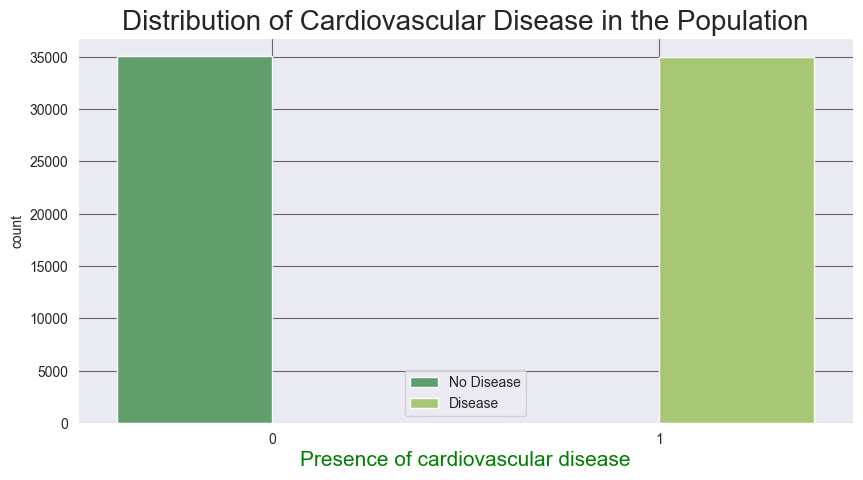

In [14]:
sns.set_style('darkgrid')
plt.figure(figsize=(10, 5))
sns.countplot(x='cardio', data=df2, palette='summer', hue='cardio')
plt.xlabel('Presence of cardiovascular disease', fontdict={'fontsize': 15,'color':'Green'}, labelpad=3)
plt.title('Distribution of Cardiovascular Disease in the Population', fontsize=20)
plt.legend(['No Disease', 'Disease'])
plt.grid(which='major', color='#666666', linestyle='-')
plt.show()


## 3.2 GENDER

women's average weight lower than men's average weight 

In [15]:
a = df3[df3["gender"]==2]["height"].mean()
b = df3[df3["gender"]==1]["height"].mean()
if a > b:
    gender = "male"
    gender1 = "female"
else:
    gender = "female"
    gender1 = "male"
print("Gender 2 is " + gender + " e Gender 1 is " + gender1)

Gender 2 is male e Gender 1 is female


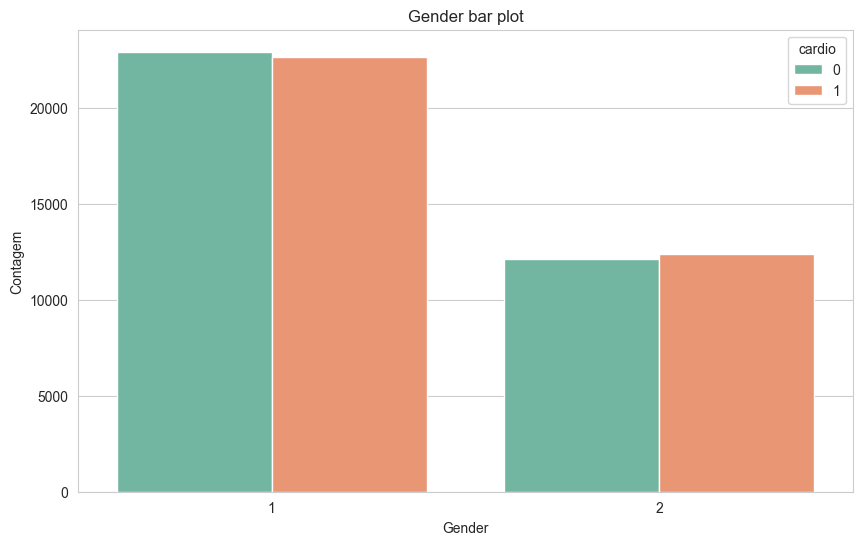

In [16]:
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))
sns.countplot(x='gender', hue='cardio', data=df2, palette="Set2")

plt.title("Gender bar plot")
plt.xlabel("Gender")
plt.ylabel("Contagem")


plt.show()

## 3.3 AGE

In [17]:
df3['age'] = df3['age'] / 365 # days for years
df3['age'] = df3['age'].round()

### 3.3.2 GENDER BY AGE

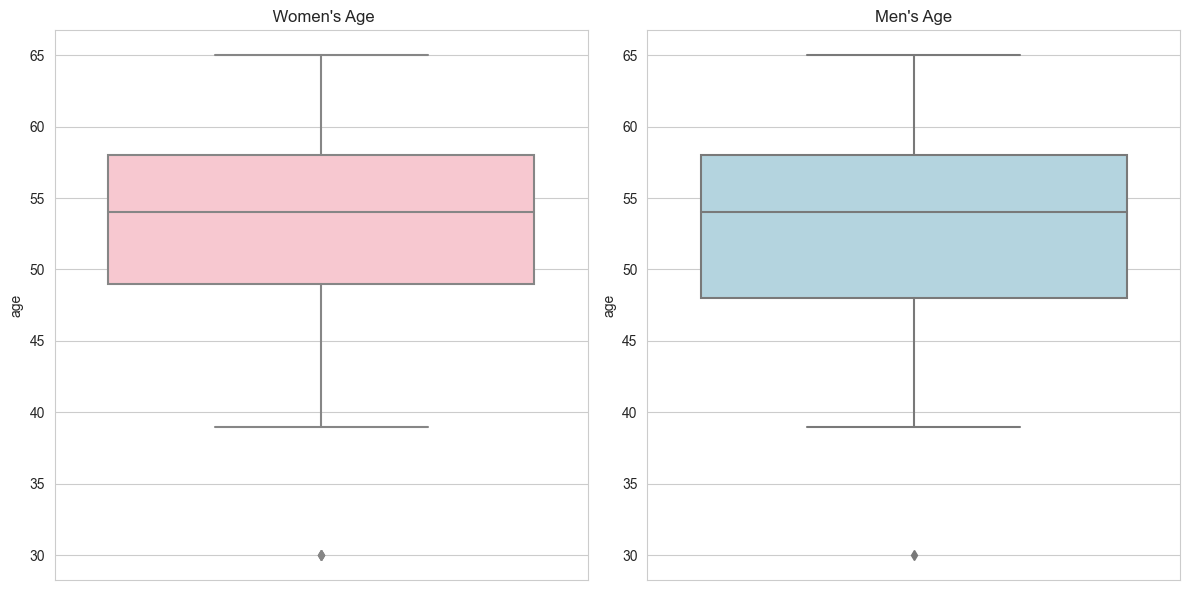

In [18]:
#gender
df_female = df3[df3['gender'] == 1]
df_male = df3[df3['gender'] == 2]

# boxplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.boxplot(data=df_female, y='age', ax=axes[0], color='pink')
sns.boxplot(data=df_male, y='age', ax=axes[1], color='lightblue')

# plot
axes[0].set_title(" Women's Age")
axes[1].set_title("Men's Age")
plt.tight_layout()
plt.show()

In [19]:
df_female[df_female['age'] <= 30]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pression,model_score
6219,8850,30.0,1,175,59.0,120,80,1,1,0,0,1,0,19,40,10883
30666,43842,30.0,1,159,59.0,120,80,1,1,0,0,1,0,23,40,10864
55905,79749,30.0,1,160,59.0,110,70,1,1,0,0,1,0,23,40,10969


In [20]:
df_male[df_male['age'] <= 30]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pression,model_score
22343,31922,30.0,2,175,92.0,100,60,1,1,0,0,1,0,30,40,10798


## 3.4 Height

### 3.4.1 VIOLIN PLOT

## 3.4.2 HEIGHT BY GENDER

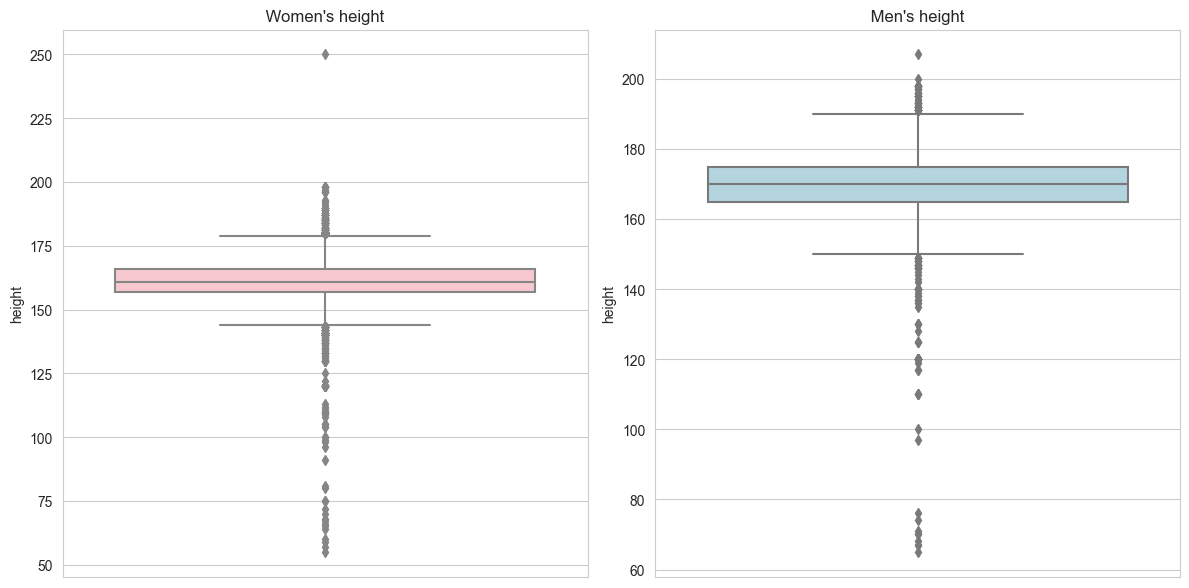

In [21]:
#gender
df_female = df3[df3['gender'] == 1]
df_male = df3[df3['gender'] == 2]

# boxplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.boxplot(data=df_female, y='height', ax=axes[0], color='pink')
sns.boxplot(data=df_male, y='height', ax=axes[1], color='lightblue')

# plot
axes[0].set_title(" Women's height ")
axes[1].set_title(" Men's height ")
plt.tight_layout()
plt.show()

In [22]:
df_female[df_female['height']> 240]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pression,model_score
6486,9223,58.0,1,250,86.0,140,100,3,1,0,0,1,1,13,40,21226


In [23]:
#filter
df3 = df3.drop(df3[(df3['height'] == 250) & (df3['gender'] == 1)].index)

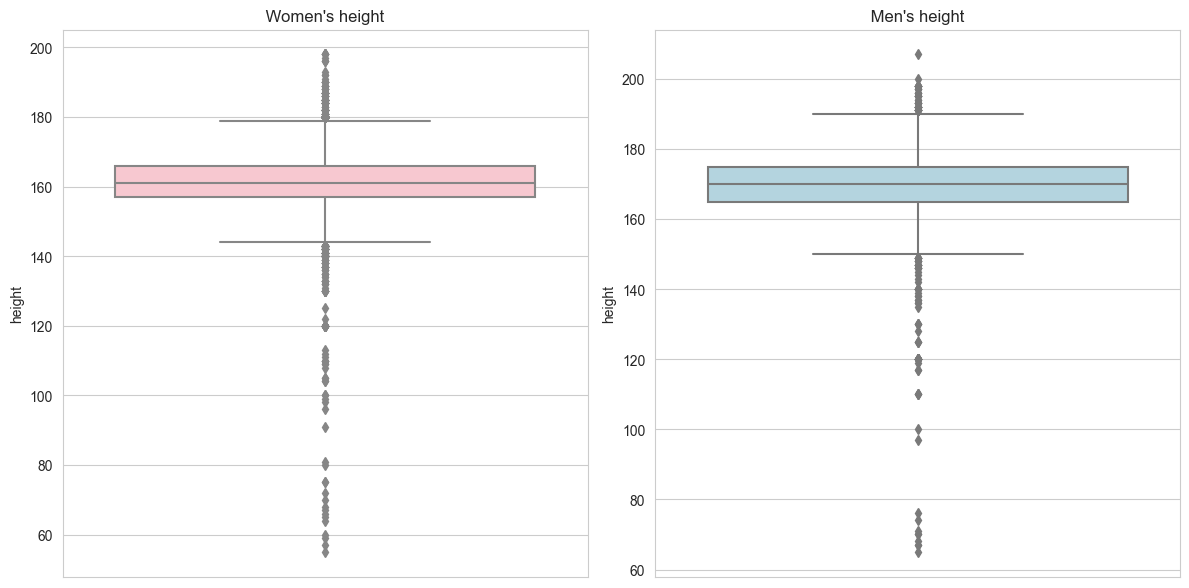

In [24]:
#gender
df_female = df3[df3['gender'] == 1]
df_male = df3[df3['gender'] == 2]

# boxplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.boxplot(data=df_female, y='height', ax=axes[0], color='pink')
sns.boxplot(data=df_male, y='height', ax=axes[1], color='lightblue')

# plot
axes[0].set_title(" Women's height ")
axes[1].set_title(" Men's height ")
plt.tight_layout()
plt.show()

## 3.5 Weight

### 3.5.1 VIOLIN PLOT

### 3.5.2 WEIGHT BY GENDER

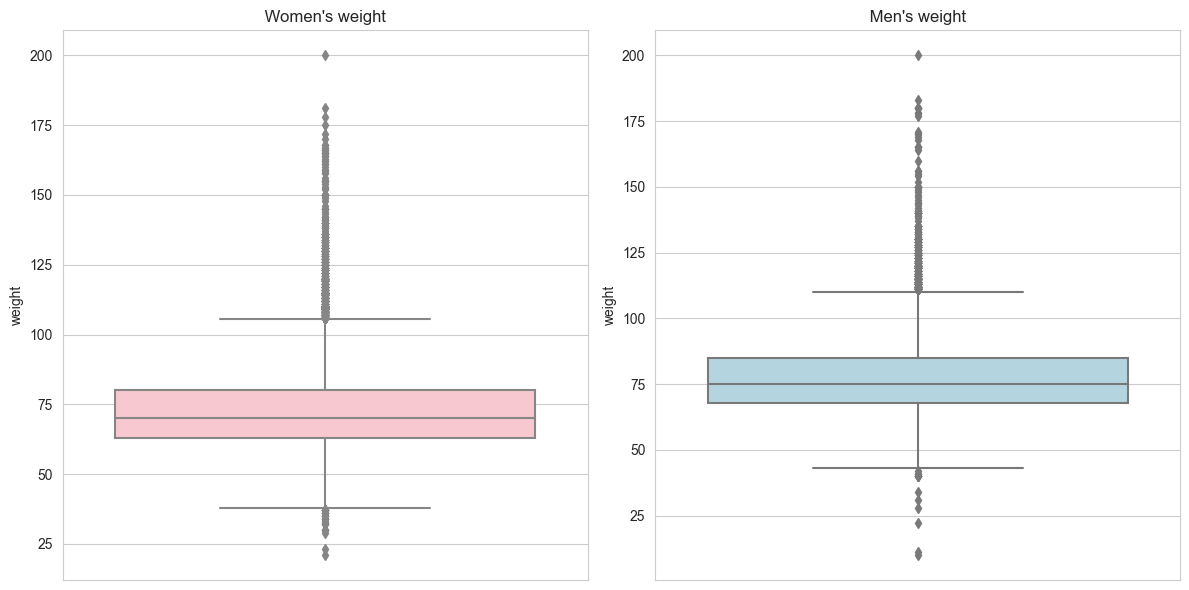

In [25]:
#gender
df_female = df3[df3['gender'] == 1]
df_male = df3[df3['gender'] == 2]

# boxplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.boxplot(data=df_female, y='weight', ax=axes[0], color='pink')
sns.boxplot(data=df_male, y='weight', ax=axes[1], color='lightblue')

# plot
axes[0].set_title(" Women's weight ")
axes[1].set_title(" Men's weight ")
plt.tight_layout()
plt.show()

## 3.6 AP_HI (systolic blood pressure)

### 3.6.1 VIOLIN PLOT

In [26]:
#filter
df3 = df3[(df3['ap_hi'] > 0) & (df3['ap_hi'] < 300)]

### 3.6.2 AP_HI BY GENDER

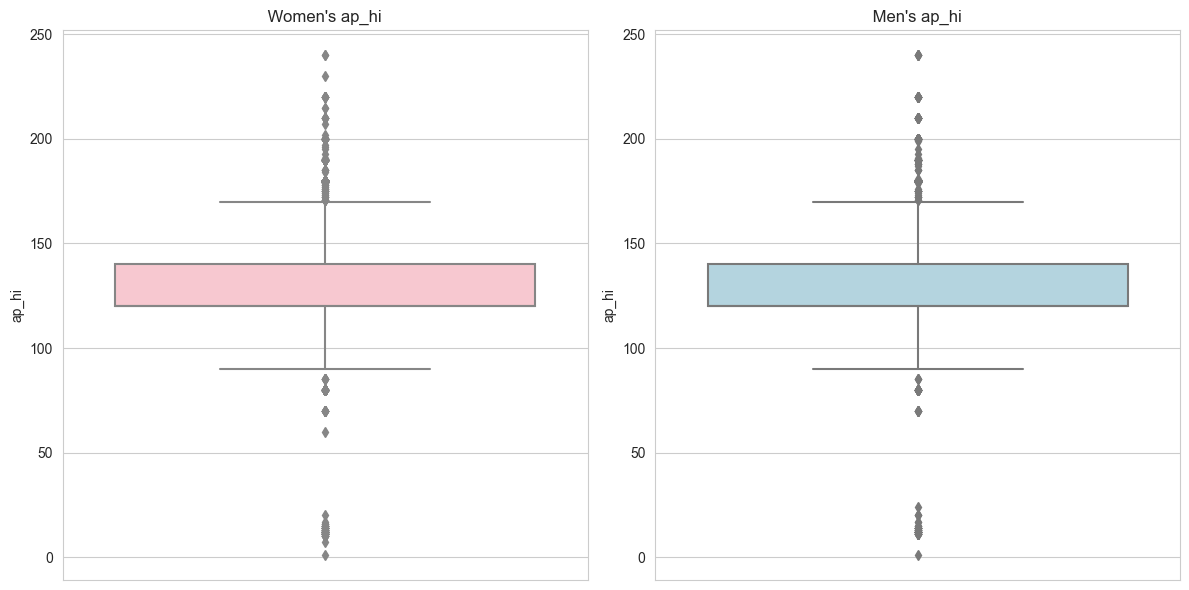

In [27]:
#gender
df_female = df3[df3['gender'] == 1]
df_male = df3[df3['gender'] == 2]

# boxplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.boxplot(data=df_female, y='ap_hi', ax=axes[0], color='pink')
sns.boxplot(data=df_male, y='ap_hi', ax=axes[1], color='lightblue')

# plot
axes[0].set_title(" Women's ap_hi ")
axes[1].set_title(" Men's ap_hi ")
plt.tight_layout()
plt.show()

## 3.7 AP_LO
     

In [28]:
df3 = df3[(df3['ap_lo'] > 0) & (df3['ap_lo'] < 300)]

### 3.7.2 AP_LO BY GENDER

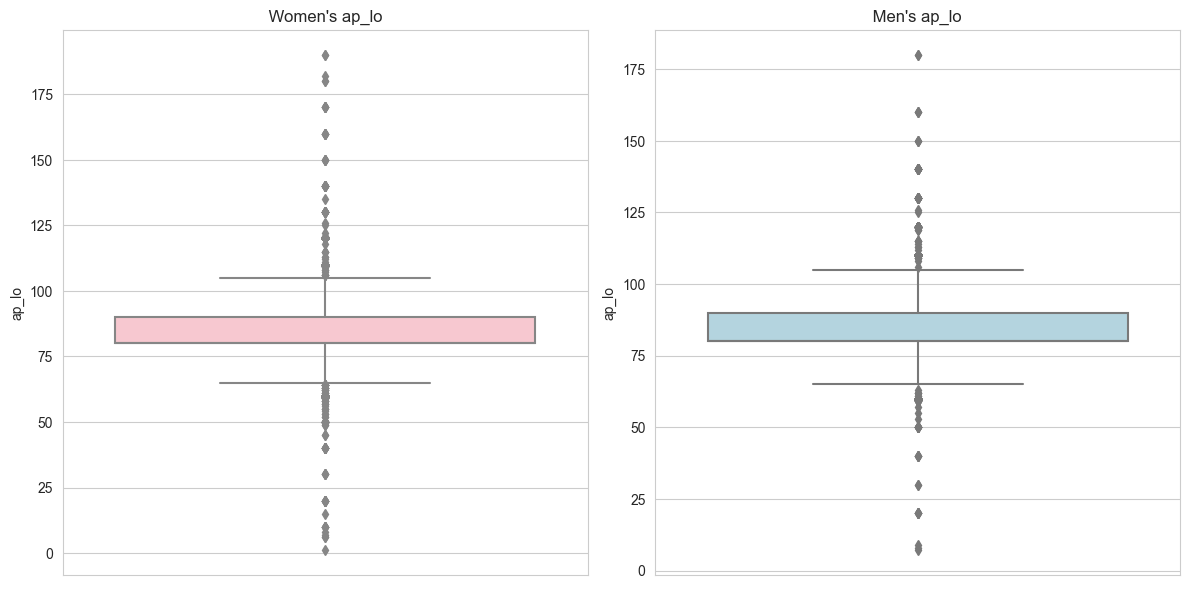

In [29]:
#gender
df_female = df3[df3['gender'] == 1]
df_male = df3[df3['gender'] == 2]

# boxplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.boxplot(data=df_female, y='ap_lo', ax=axes[0], color='pink')
sns.boxplot(data=df_male, y='ap_lo', ax=axes[1], color='lightblue')

# plot
axes[0].set_title(" Women's ap_lo ")
axes[1].set_title(" Men's ap_lo ")
plt.tight_layout()
plt.show()

## 3.8 CHOLESTEROL

In [30]:
df3['cholesterol']=df3['cholesterol'].map({ 1: 'normal', 2: 'above normal', 3: 'well above normal'})

### 3.8.1 BAR PLOT

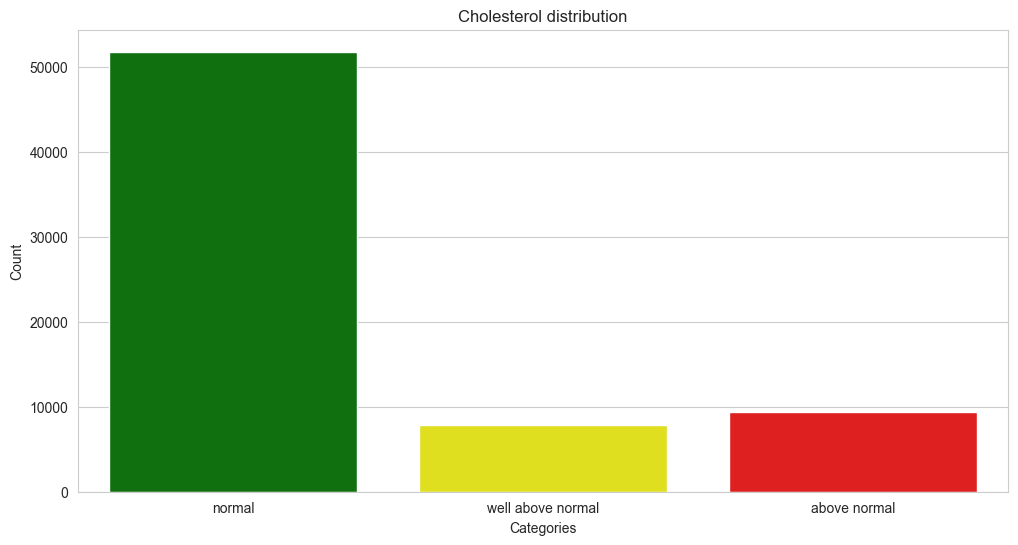

In [31]:
sns.countplot(x='cholesterol', data=df3, palette=['green', 'yellow', 'red'])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Cholesterol distribution')

fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.show()

### 3.8.2 CHOLESTEROL BY GENDER

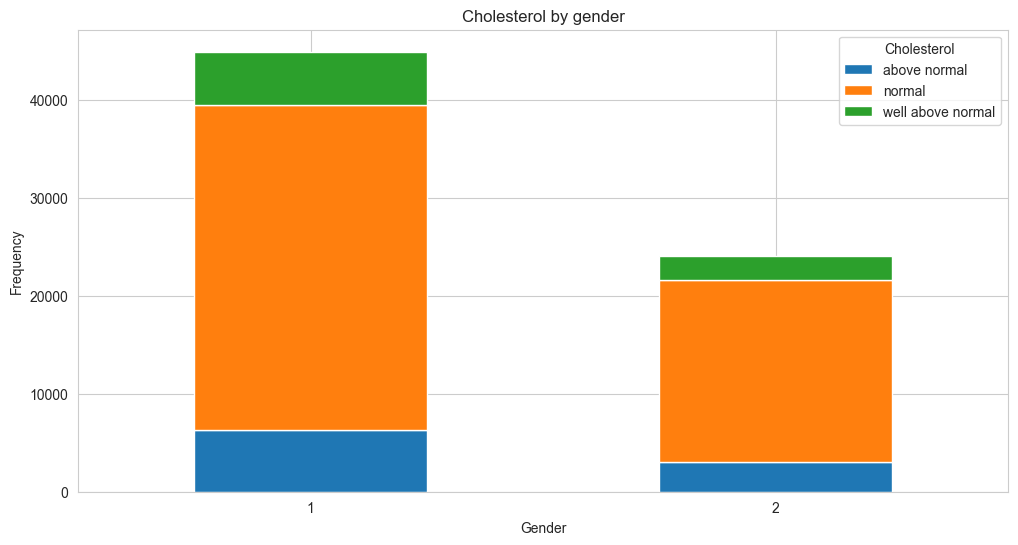

In [32]:
#contigency_table
contingency_table = pd.crosstab(df3['gender'], df3['cholesterol'])
contingency_table.plot(kind='bar', stacked=True, figsize=(12,6))
#plot
plt.title('Cholesterol by gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Cholesterol')

plt.show()

## 3.9 GLUCOSE


In [33]:
df3['gluc']=df3['gluc'].map({ 1: 'normal', 2: 'above normal', 3: 'well above normal'})

### 3.9.1 BAR PLOT

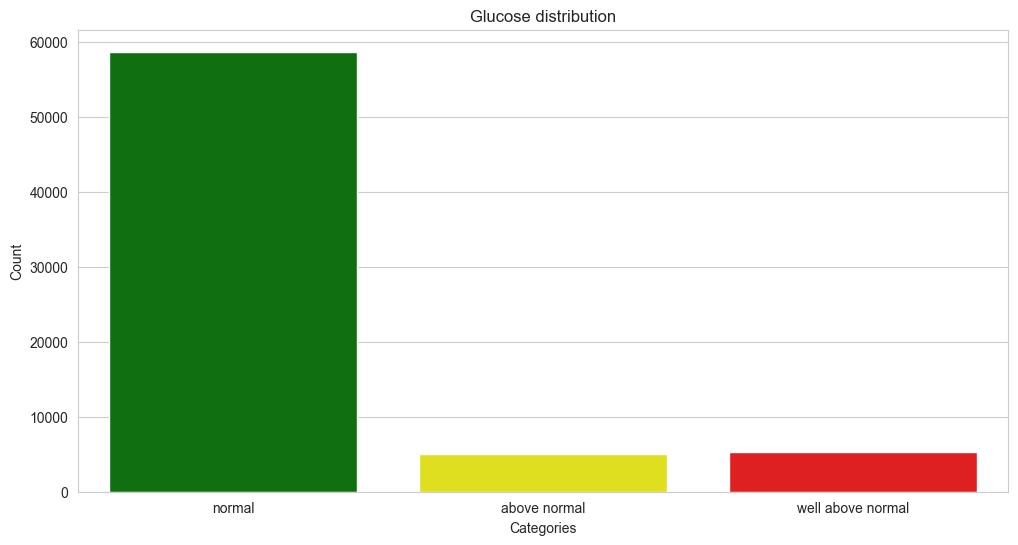

In [34]:
sns.countplot(x='gluc', data=df3, palette=['green', 'yellow', 'red'])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Glucose distribution')

fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.show()

### 3.9.2 GLUCOSE BY GENDER

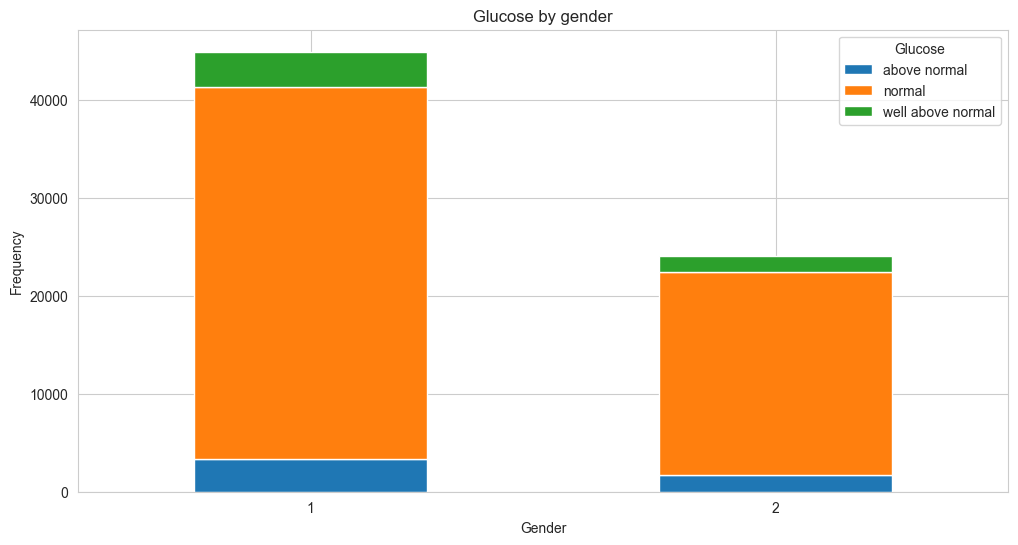

In [35]:
#contigency_table
contingency_table = pd.crosstab(df2['gender'], df3['gluc'])
contingency_table.plot(kind='bar', stacked=True, figsize=(12,6))
#plot
plt.title('Glucose by gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Glucose')

plt.show()

## 3.10 SMOKE

In [36]:
df3['smoke']=df3['smoke'].map({ 0: 'not a smoker', 1: 'smoker'})

### 3.10.1 BAR PLOT

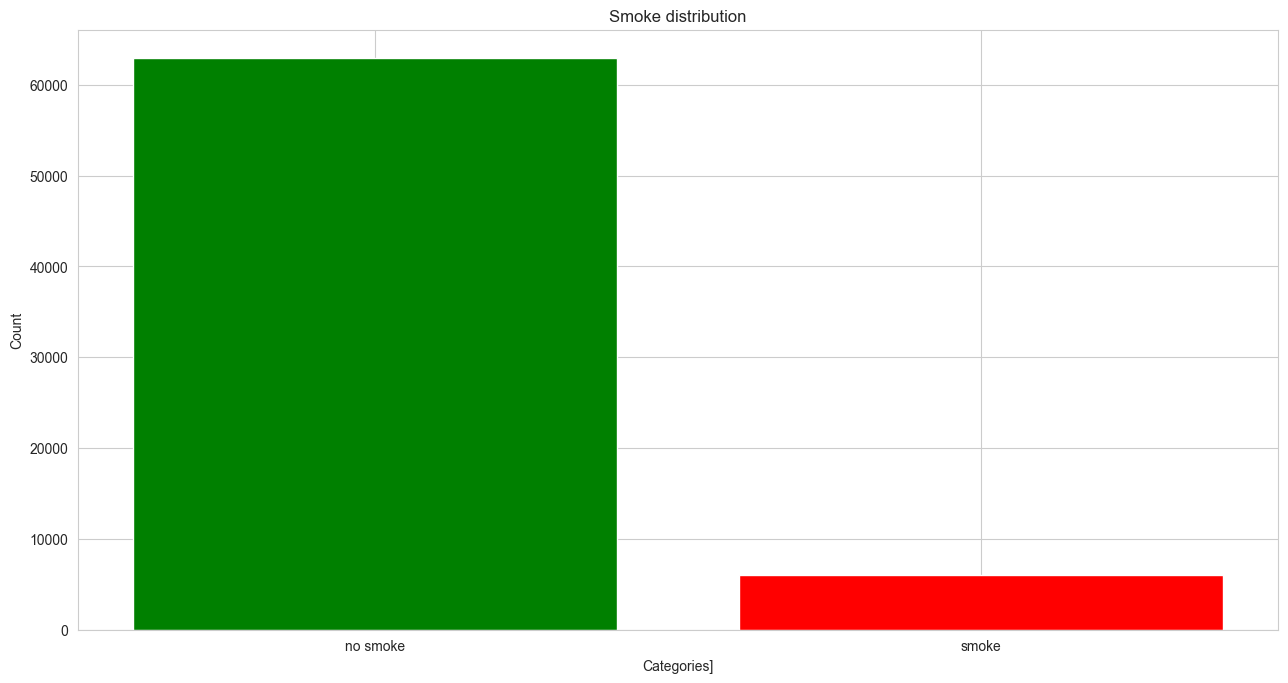

In [37]:
glucose = df3['smoke'].value_counts()
categories = ['no smoke', 'smoke']
colors = ['green','red']

fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(categories, glucose , color= colors)

plt.xlabel('Categories]')
plt.ylabel('Count')
plt.title('Smoke distribution')

plt.show()

### 3.10.2 SMOKE BY GENDER

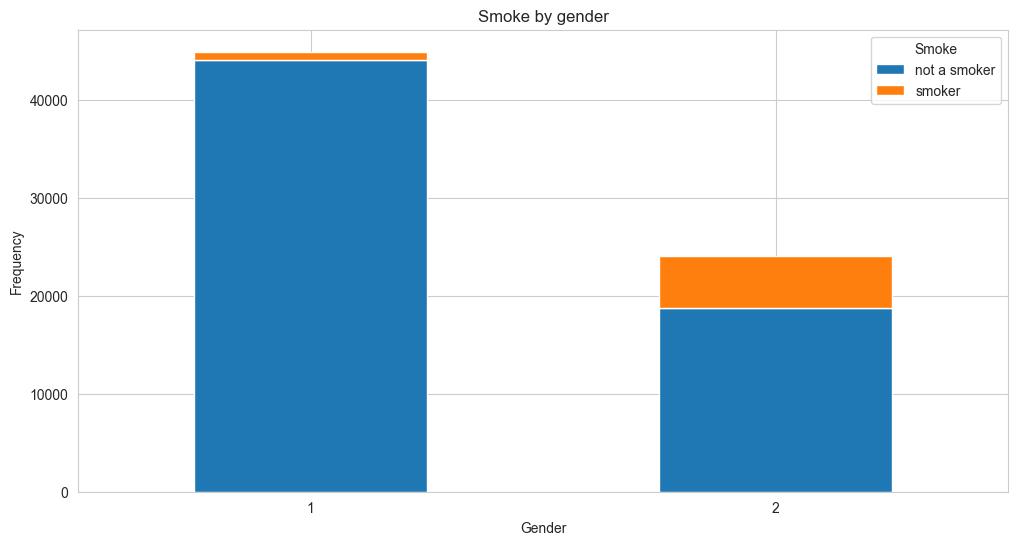

In [38]:
#contigency_table
contingency_table = pd.crosstab(df3['gender'], df3['smoke'])
contingency_table.plot(kind='bar', stacked=True, figsize=(12,6))
#plot
plt.title('Smoke by gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Smoke')

plt.show()

## 3.11 ALCO

In [39]:
df3['alco']=df3['alco'].map({ 0: 'no drink', 1: 'drink'})

### 3.11.1 BAR PLOT

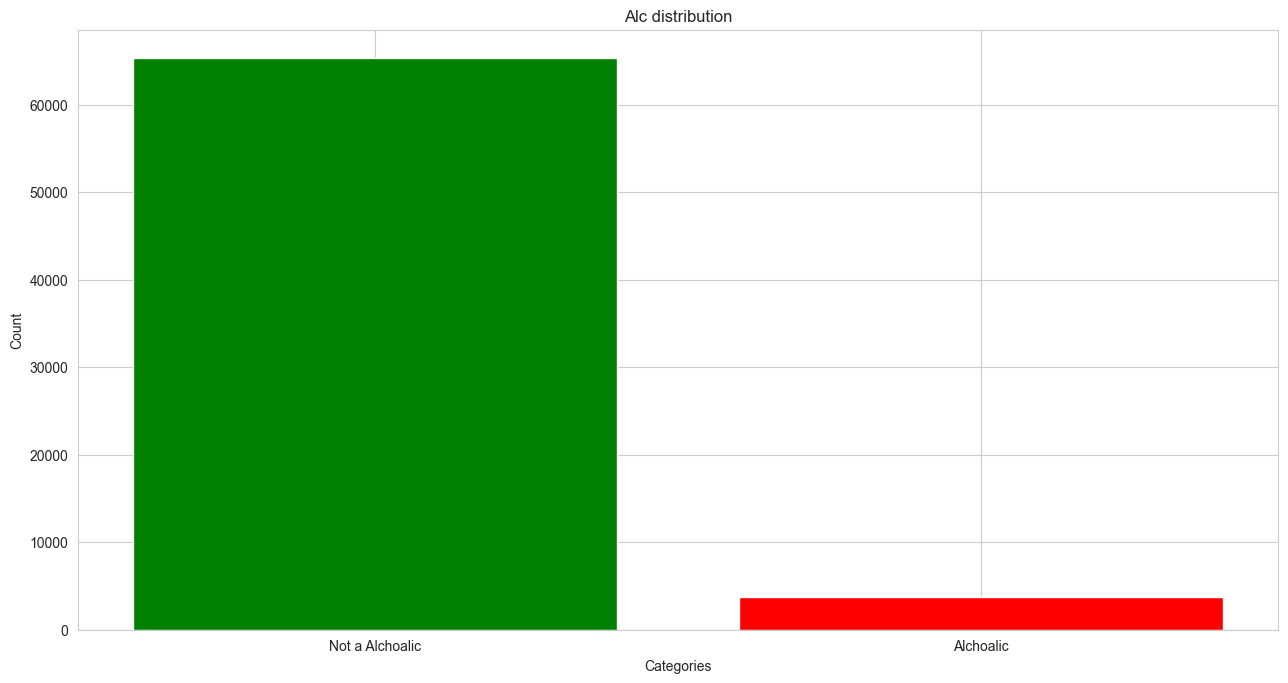

In [40]:
glucose = df3['alco'].value_counts()
categories = ['Not a Alchoalic', 'Alchoalic']
colors = ['green','red']

fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(categories, glucose , color= colors)

plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Alc distribution')

plt.show()

### 3.11.2 ALCOHOLIC BY GENDER

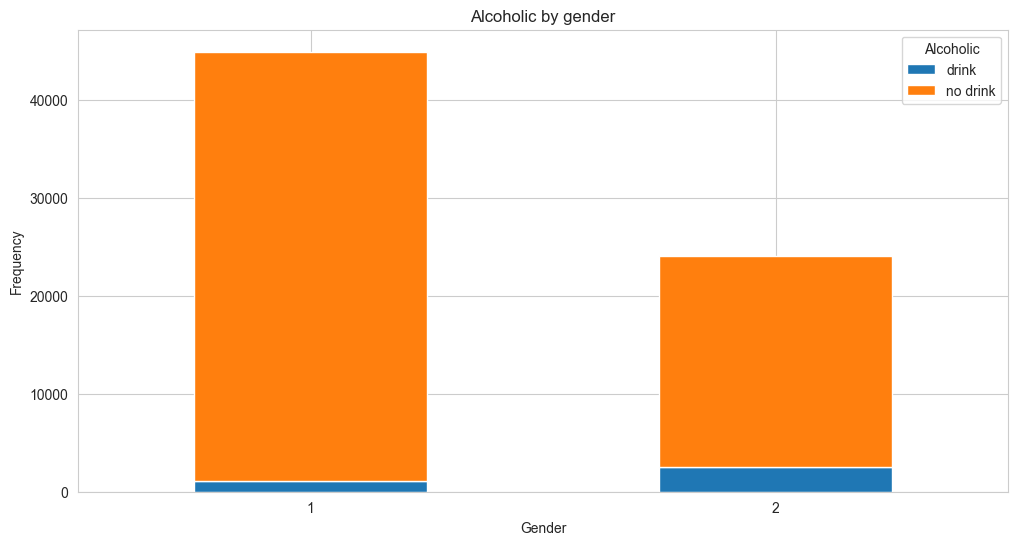

In [41]:
#contigency_table
contingency_table = pd.crosstab(df3['gender'], df3['alco'])
contingency_table.plot(kind='bar', stacked=True, figsize=(12,6))
#plot
plt.title('Alcoholic by gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Alcoholic')

plt.show()

## 3.12 ACTIVE

In [42]:
df3['active']=df3['active'].map({ 0: 'no active', 1: 'active'})

### 3.12.1 BAR PLOT

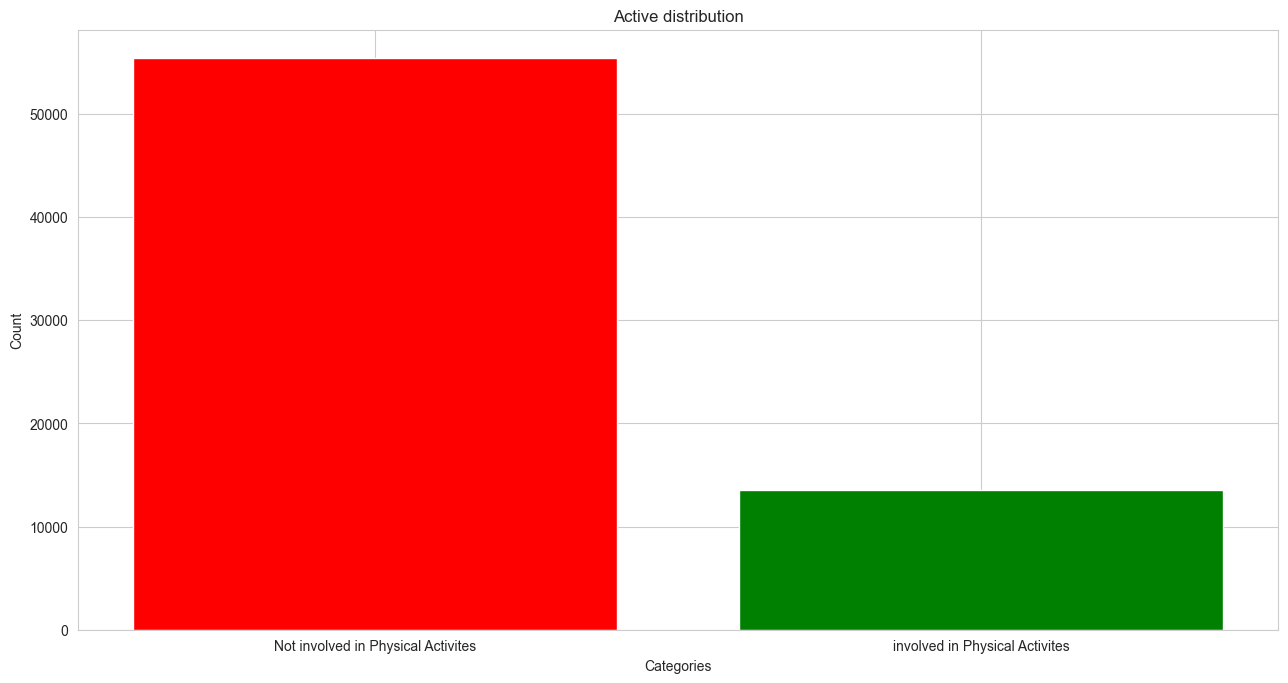

In [43]:
active = df3['active'].value_counts()
categories = ['Not involved in Physical Activites', 'involved in Physical Activites']
colors = ['red','green']

fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0,0,1,1])
ax.bar(categories, active , color= colors)

plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Active distribution')

plt.show()

### 3.12.2 ACTIVE BY GENDER

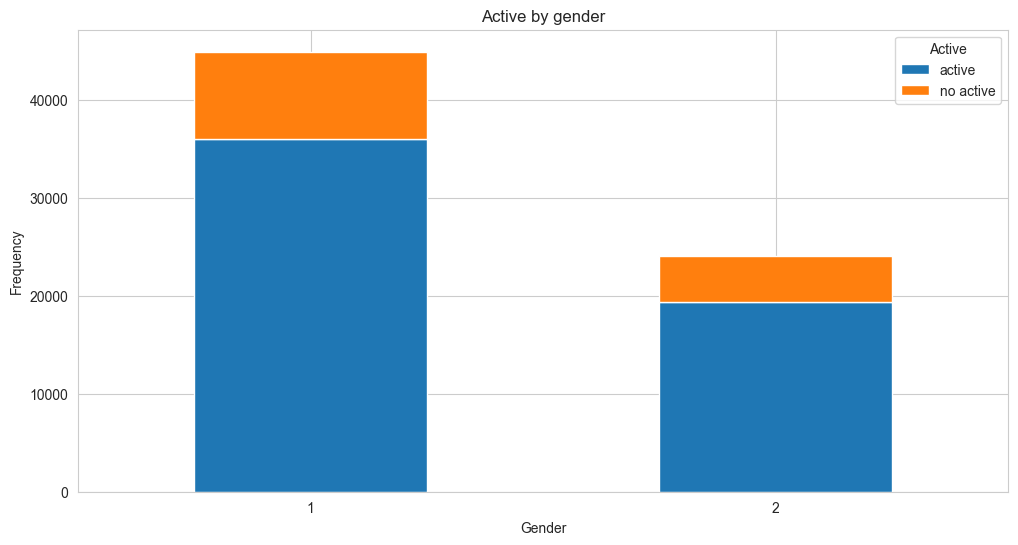

In [44]:
#contigency_table
contingency_table = pd.crosstab(df3['gender'], df3['active'])
contingency_table.plot(kind='bar', stacked=True, figsize=(12,6))
#plot
plt.title('Active by gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Active')

plt.show()

# 4.0 OUTLIERS

In [45]:
df4 = df3.copy()

In [46]:
def outliers(df_out, drop = False):
    for each_feature in df_out.columns:
        feature_data = df_out[each_feature]
        Q1 = np.percentile(feature_data, 25.) # 25th percentile of the data of the given feature
        Q3 = np.percentile(feature_data, 75.) # 75th percentile of the data of the given feature
        IQR = Q3-Q1 #Interquartile Range
        outlier_step = IQR * 1.5 #That's we were talking about above
        outliers = feature_data[~((feature_data >= Q1 - outlier_step) & (feature_data <= Q3 + outlier_step))].index.tolist()  
        print('For the feature {}, No of Outliers is {} and No of Data is {}'.format(each_feature, len(outliers),df4[each_feature].shape[0]))
outliers(df4[['weight','age','ap_hi','ap_lo']])

For the feature weight, No of Outliers is 1752 and No of Data is 68984
For the feature age, No of Outliers is 4 and No of Data is 68984
For the feature ap_hi, No of Outliers is 1245 and No of Data is 68984
For the feature ap_lo, No of Outliers is 3651 and No of Data is 68984


# 5.0 PREPOCESSING

In [47]:
df5 = df4.drop('id', axis=1).copy()

In [48]:
df5.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,pulse_pression,model_score
0,50.0,2,168,62.0,110,80,normal,normal,not a smoker,no drink,active,0,21,30,18393
1,55.0,1,156,85.0,140,90,well above normal,normal,not a smoker,no drink,active,1,34,50,20234
2,52.0,1,165,64.0,130,70,well above normal,normal,not a smoker,no drink,no active,1,23,60,18863
3,48.0,2,169,82.0,150,100,normal,normal,not a smoker,no drink,active,1,28,50,17624
4,48.0,1,156,56.0,100,60,normal,normal,not a smoker,no drink,no active,0,23,40,17479


In [49]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [50]:
# One-hot encoding
df5 = pd.get_dummies(df5, columns=['cholesterol', 'gluc'])

# Binary
df5['smoke'] = df5['smoke'].replace({'not a smoker': 0, 'smoker': 1})
df5['alco'] = df5['alco'].replace({'no drink': 0, 'drink': 1})
df5['active'] = df5['active'].replace({'no active': 0, 'active': 1})
df5['gender'] = df5['gender'].replace({ 1: 0, 2: 1})

# MinMaxScaler
minmax_scaler = MinMaxScaler()
df5[['age', 'bmi', 'model_score']] = minmax_scaler.fit_transform(df5[['age', 'bmi', 'model_score']])

# StandardScaler
standard_scaler = StandardScaler()
df5[['height', 'weight', 'ap_hi', 'ap_lo', 'pulse_pression']] = standard_scaler.fit_transform(df5[['height', 'weight', 'ap_hi', 'ap_lo', 'pulse_pression']])

# Save models
with open('one_hot_encoding.pkl', 'wb') as f:
    pickle.dump(df5, f)

with open('binary_encoding.pkl', 'wb') as f:
    pickle.dump(df5[['smoke', 'alco', 'active', 'gender']], f)

with open('minmax_scaler.pkl', 'wb') as f:
    pickle.dump(minmax_scaler, f)

with open('standard_scaler.pkl', 'wb') as f:
    pickle.dump(standard_scaler, f)

In [51]:
df5.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,bmi,pulse_pression,model_score,cholesterol_above normal,cholesterol_normal,cholesterol_well above normal,gluc_above normal,gluc_normal,gluc_well above normal
0,0.571429,1,0.444213,-0.845760,-0.922383,-0.137701,0,0,1,0,0.061017,-1.104603,0.588076,0,1,0,0,1,0
1,0.714286,0,-1.019596,0.759391,0.772672,0.882145,0,0,1,1,0.105085,0.370697,0.730623,0,0,1,0,1,0
2,0.628571,0,0.078261,-0.706182,0.207654,-1.157546,0,0,0,1,0.067797,1.108348,0.624468,0,0,1,0,1,0
3,0.514286,1,0.566198,0.550023,1.337690,1.901990,0,0,1,1,0.084746,0.370697,0.528533,0,1,0,0,1,0
4,0.514286,0,-1.019596,-1.264496,-1.487401,-2.177391,0,0,0,0,0.067797,-0.366953,0.517305,0,1,0,0,1,0


## 5.3 Correlation of Variables

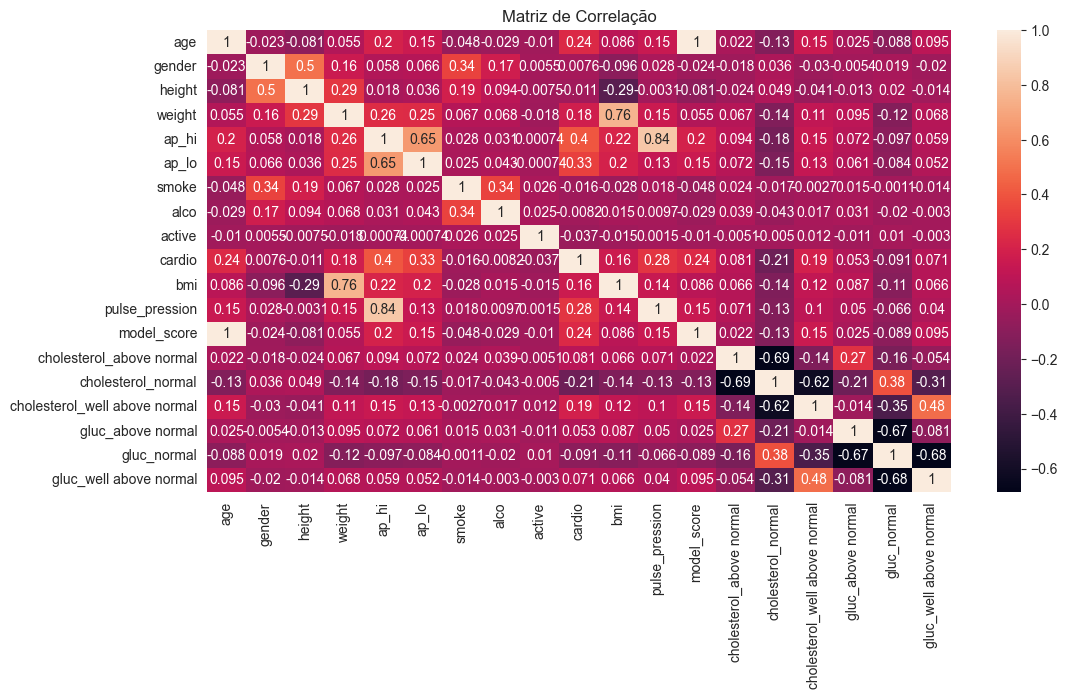

In [52]:
corr = df5.corr()

# plot
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True)
plt.title('Matriz de Correlação')
plt.show()

## 5.4 CORRELATION WITH TARGET

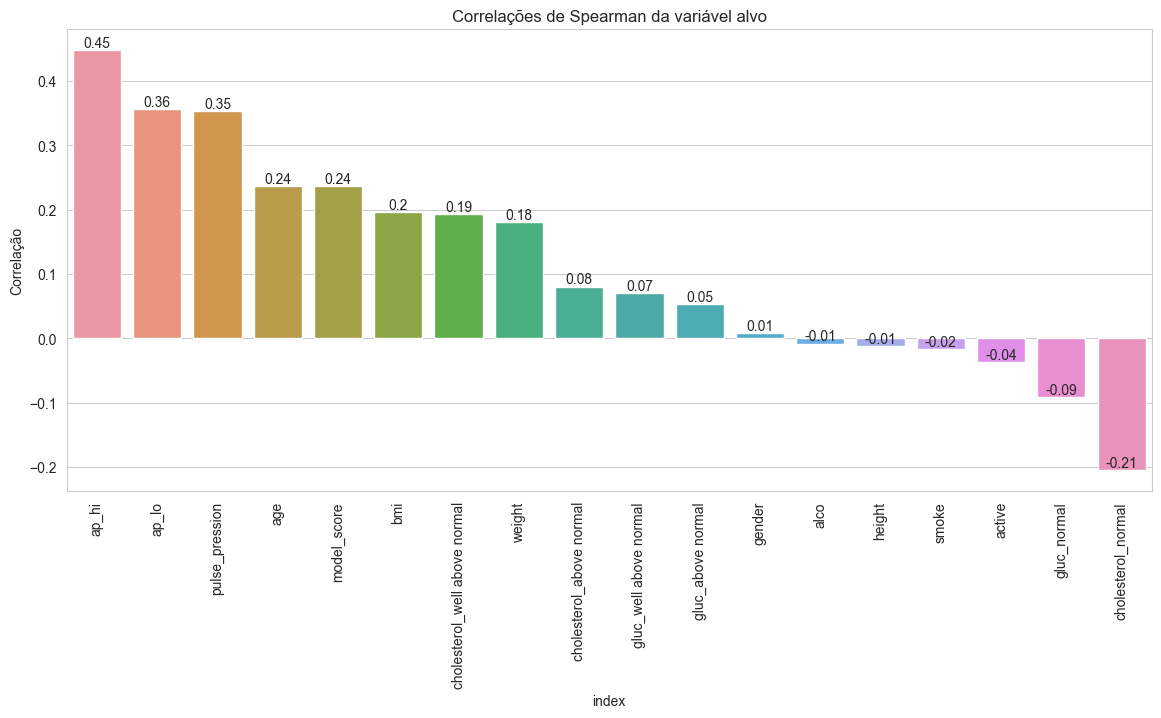

In [53]:
corr = df5.corr(method='spearman')


target_corr = corr.loc['cardio']
target_corr = target_corr.sort_values(ascending=False)
target_corr = target_corr.drop('cardio')
target_corr = pd.DataFrame(target_corr)
target_corr['index'] = target_corr.index
target_corr = target_corr.reset_index(drop=True)

# plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=target_corr['index'], y=target_corr['cardio'])
plt.title('Correlações de Spearman da variável alvo')
plt.ylabel('Correlação')
plt.xticks(rotation=90)

# values
for i, v in enumerate(target_corr['cardio']):
    ax.text(i, v, round(v, 2), ha='center', va='bottom')

plt.show()

# 6.0 MACHINE LEARNING

In [54]:
final_data = df5.copy()

In [55]:
final_data.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'smoke', 'alco',
       'active', 'cardio', 'bmi', 'pulse_pression', 'model_score',
       'cholesterol_above normal', 'cholesterol_normal',
       'cholesterol_well above normal', 'gluc_above normal', 'gluc_normal',
       'gluc_well above normal'],
      dtype='object')

### 6.1 SPLITTING AND STANDARDIZING DATA

In [56]:
cols = ['ap_hi','age','model_score','bmi','cholesterol_normal']
X = df5[cols]
y = df5['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
X_train

,ap_hi,age,model_score,bmi,cholesterol_normal
34385,-0.922383,0.600000,0.614712,0.064407,1
44898,0.207654,0.771429,0.767093,0.081356,0
14760,0.772672,0.800000,0.804955,0.091525,0
66016,1.902708,0.742857,0.739837,0.088136,0
15706,0.772672,0.942857,0.955478,0.094915,1
...,...,...,...,...,...
37741,1.337690,0.514286,0.527062,0.084746,0
6357,-0.357364,0.571429,0.584669,0.074576,1
55680,3.597763,0.885714,0.896787,0.094915,1
871,0.207654,0.685714,0.678204,0.088136,0


In [58]:
X_test

,ap_hi,age,model_score,bmi,cholesterol_normal
16622,-0.357364,0.314286,0.311808,0.094915,0
41666,-0.922383,0.685714,0.680449,0.115254,1
48369,-0.922383,0.942857,0.937747,0.071186,0
48097,-0.357364,0.514286,0.522648,0.067797,1
68766,-0.357364,0.828571,0.821293,0.057627,1
...,...,...,...,...,...
48235,1.281188,0.857143,0.863724,0.115254,0
38921,1.337690,0.914286,0.910724,0.077966,1
10139,-0.357364,0.285714,0.305459,0.098305,1
39533,-0.357364,0.971429,0.979791,0.067797,1


In [59]:
y_train

34385    1
44898    0
14760    1
66016    1
15706    1
        ..
37741    1
6357     1
55680    0
871      0
16025    0
Name: cardio, Length: 55187, dtype: int64

## 6.2 K-NEAREST NEIGHBORS

In [60]:
#start_time = time.time()

#error_rate = []
#for i in range(1, 31):
     #knn = KNeighborsClassifier(n_neighbors=i)
     #scores = cross_val_score(knn, X_train, y_train, cv=10)
     #error_rate.append(1 - np.mean(scores))

#plt.figure(figsize=(10,6))
#plt.plot(range(1, 31), error_rate, color='blue', linestyle='dashed', marker='o',
          #markerfacecolor='red', markersize=10)
#plt.title('Error Rate vs. K Value')
#plt.xlabel('K')
#plt.ylabel('Error Rate');

#best_k = np.argmin(error_rate) + 1
#print(f"Best K: {best_k}")

#end_time = time.time()  # Registra o tempo de término
#total_time = end_time - start_time  

#print("Time: {:.2f} segundos".format(total_time))

In [61]:
#best_k =29

In [62]:
#best_knn = KNeighborsClassifier(n_neighbors=best_k)
#best_knn.fit(X_train, y_train)

#y_pred = best_knn.predict(X_test)

#print(classification_report(y_test, y_pred))

In [63]:
#cm = confusion_matrix(y_test, y_pred)

## Plot
#fig, ax = plt.subplots(figsize=(10, 8))
#plot_confusion_matrix(best_knn, X_test, y_test, cmap=plt.cm.Blues, values_format='.0f', ax=ax)
#plt.show()

In [64]:
#with open('knn_model.pkl', 'wb') as f:
    #pickle.dump(best_knn, f)

## 6.3 RANDOM FOREST

In [65]:
# start_time = time.time()

# param_grid = {'max_depth': [80, 90],
#                'max_features': [2, 3, 4],
#                'min_samples_leaf': [3, 4],
#                'min_samples_split': [8, 10],
#                'n_estimators': [100, 150, 200]}


# rf = RandomForestClassifier(criterion='gini', bootstrap=True, oob_score=False)

# # GRID SEARCH
# grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=1)
# grid.fit(X_train, y_train)


# best_model = grid.best_estimator_
# print("Melhores parâmetros: ", grid.best_params_)


# end_time = time.time()
# total_time = end_time - start_time


# print("Time: {:.2f} segundos".format(total_time))

In [66]:
#params = {
    # 'max_depth': 90,
    # 'max_features': 2,
   #  'min_samples_leaf': 4,
   #  'min_samples_split': 10,
   #  'n_estimators': 100
# }

#best_model = RandomForestClassifier(**params)

##predict

#best_model.fit(X_train, y_train)
#y_pred = best_model.predict(X_test)

## Classification Report
#report = classification_report(y_test, y_pred)
#print(report)

In [67]:
#cm = confusion_matrix(y_test, y_pred)

## plot
#plt.figure(figsize=(12, 6))
#sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
#plt.title("Confusion Matrix")
#plt.xlabel("Predicted label")
#plt.ylabel("True label")
#plt.show()

In [68]:
#filename = 'rf.pkl'

#pickle.dump(best_model, open(filename, 'wb'))

## 6.4 XGBOOST

In [69]:
# start_time = time.time() 

# # Hyperparams
# param_grid = {
#      'learning_rate': [0.1, 0.5],
#      'n_estimators': [100, 200],
#      'max_depth': [3, 5],
#      'min_child_weight': [1, 3],
#      'gamma': [00.1, 0.2]
#  }

# xgb_model = xgb.XGBClassifier()

# # GRIDSEARCH
# grid_search = GridSearchCV(xgb_model, param_grid, cv=10)
# grid_search.fit(X_train, y_train)

# # best hyperparameters
# print("Best hyperparameters: ", grid_search.best_params_)

# end_time = time.time()  
# total_time = end_time - start_time 

# print("Time: {:.2f} segundos".format(total_time))

In [70]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [71]:
import xgboost as xgb

In [72]:
params = {
     'gamma': 0.2,
     'learning_rate': 0.1,
     'max_depth': 5,
     'min_child_weight': 1,
     'n_estimators': 200
 }

best_model = xgb.XGBClassifier(**params)

# predict
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Classification Report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      7026
           1       0.74      0.70      0.72      6771

    accuracy                           0.73     13797
   macro avg       0.73      0.73      0.73     13797
weighted avg       0.73      0.73      0.73     13797



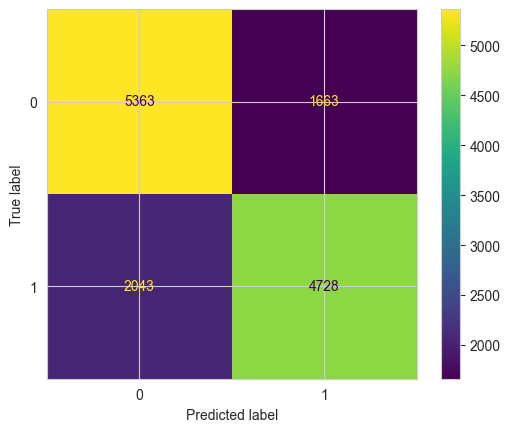

In [73]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# 7.0 DEPLOY

In [74]:
import pickle

# Salvar o modelo em um arquivo
filename = 'xgboost_model.pkl'
pickle.dump(best_model, open(filename, 'wb'))

In [75]:
#from flask import Flask, render_template, request
#import numpy as np
#import xgboost as xgb

#app = Flask(__name__)

#@app.route('/')
#def index():
  #  return render_template('form.html')

#@app.route('/submit', methods=['POST'])
#def submit():
    #ap_hi = request.form['ap_hi']
    #age = request.form['age']
    #model_score = request.form['model_score']
    #bmi = request.form['bmi']
    #cholesterol_normal = request.form['cholesterol_normal']
    ## Faça algo com os dados, como salvá-los em um banco de dados ou calculá-los
    #return 'Dados recebidos com sucesso!'

#if __name__ == '__main__':
    #app.run(debug=False)